In [1]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.science.utilities import portfolio_utils, lstm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '1995-01-01'
date_end = '2005-01-01'
query = f'''
    with 
    tickers as (
        select distinct 
            ticker
            , sector
            , industry
        from nasdaq.listed_stocks
        where ticker !~ '[\^.~]'
            and character_length(ticker) between 1 and 4
            and ticker = 'KO'
        limit 30
        )
    , lagged as (
        select
            symbol
            , market_datetime
            , max(open) over (partition by symbol order by market_datetime rows between 1 following and 31 following) as open
            , lag(open, 1) over (partition by symbol order by market_datetime) as open_1
            , lag(open, 2) over (partition by symbol order by market_datetime) as open_2
            , lag(open, 3) over (partition by symbol order by market_datetime) as open_3
            , lag(open, 4) over (partition by symbol order by market_datetime) as open_4
            , lag(open, 5) over (partition by symbol order by market_datetime) as open_5
            , lag(open, 6) over (partition by symbol order by market_datetime) as open_6
            , lag(open, 7) over (partition by symbol order by market_datetime) as open_7
            , lag(open, 8) over (partition by symbol order by market_datetime) as open_8
            , lag(open, 9) over (partition by symbol order by market_datetime) as open_9
            , lag(open, 10) over (partition by symbol order by market_datetime) as open_10
            , lag(open, 11) over (partition by symbol order by market_datetime) as open_11
            , lag(open, 12) over (partition by symbol order by market_datetime) as open_12
            , lag(open, 13) over (partition by symbol order by market_datetime) as open_13
            , lag(open, 14) over (partition by symbol order by market_datetime) as open_14
            , lag(open, 15) over (partition by symbol order by market_datetime) as open_15
            , lag(open, 16) over (partition by symbol order by market_datetime) as open_16
            , lag(open, 17) over (partition by symbol order by market_datetime) as open_17
            , lag(open, 18) over (partition by symbol order by market_datetime) as open_18
            , lag(open, 19) over (partition by symbol order by market_datetime) as open_19
            , lag(open, 20) over (partition by symbol order by market_datetime) as open_20
            , lag(open, 21) over (partition by symbol order by market_datetime) as open_21
            , lag(open, 22) over (partition by symbol order by market_datetime) as open_22
            , lag(open, 23) over (partition by symbol order by market_datetime) as open_23
            , lag(open, 24) over (partition by symbol order by market_datetime) as open_24
            , lag(open, 25) over (partition by symbol order by market_datetime) as open_25
            , lag(open, 26) over (partition by symbol order by market_datetime) as open_26
            , lag(open, 27) over (partition by symbol order by market_datetime) as open_27
            , lag(open, 28) over (partition by symbol order by market_datetime) as open_28
            , lag(open, 29) over (partition by symbol order by market_datetime) as open_29
            , lag(open, 30) over (partition by symbol order by market_datetime) as open_30
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '{date_start}' and market_datetime < '{date_end}'
        )
    , summarized as (
        select *
            , least(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_min
            , greatest(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_max
        from lagged
        where open_30 is not null --and open is not null
        )
    select
            symbol
            , market_datetime
            , open as denormalized_open
            , open_min
            , open_max
            , (open - open_min) / (open_max - open_min) as open
            , (open_1 - open_min) / (open_max - open_min) as open_1
            , (open_2 - open_min) / (open_max - open_min) as open_2
            , (open_3 - open_min) / (open_max - open_min) as open_3
            , (open_4 - open_min) / (open_max - open_min) as open_4
            , (open_5 - open_min) / (open_max - open_min) as open_5
            , (open_6 - open_min) / (open_max - open_min) as open_6
            , (open_7 - open_min) / (open_max - open_min) as open_7
            , (open_8 - open_min) / (open_max - open_min) as open_8
            , (open_9 - open_min) / (open_max - open_min) as open_9
            , (open_10 - open_min) / (open_max - open_min) as open_10
            , (open_11 - open_min) / (open_max - open_min) as open_11
            , (open_12 - open_min) / (open_max - open_min) as open_12
            , (open_13 - open_min) / (open_max - open_min) as open_13
            , (open_14 - open_min) / (open_max - open_min) as open_14
            , (open_15 - open_min) / (open_max - open_min) as open_15
            , (open_16 - open_min) / (open_max - open_min) as open_16
            , (open_17 - open_min) / (open_max - open_min) as open_17
            , (open_18 - open_min) / (open_max - open_min) as open_18
            , (open_19 - open_min) / (open_max - open_min) as open_19
            , (open_20 - open_min) / (open_max - open_min) as open_20
            , (open_21 - open_min) / (open_max - open_min) as open_21
            , (open_22 - open_min) / (open_max - open_min) as open_22
            , (open_23 - open_min) / (open_max - open_min) as open_23
            , (open_24 - open_min) / (open_max - open_min) as open_24
            , (open_25 - open_min) / (open_max - open_min) as open_25
            , (open_26 - open_min) / (open_max - open_min) as open_26
            , (open_27 - open_min) / (open_max - open_min) as open_27
            , (open_28 - open_min) / (open_max - open_min) as open_28
            , (open_29 - open_min) / (open_max - open_min) as open_29
            , (open_30 - open_min) / (open_max - open_min) as open_30
    from summarized
    order by market_datetime, symbol
    '''

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,denormalized_open,open_min,open_max,open,open_1,open_2,open_3,open_4,...,open_21,open_22,open_23,open_24,open_25,open_26,open_27,open_28,open_29,open_30
0,KO,1999-11-01 06:00:00,34.09375,23.78125,29.40625,1.833333,1.000000,0.888889,0.705556,0.777778,...,0.061111,0.116667,0.283333,0.305556,0.316667,0.300000,0.433333,0.544444,0.594444,0.572222
1,KO,1999-11-02 06:00:00,34.09375,23.78125,29.50000,1.803279,1.000000,0.983607,0.874317,0.693989,...,0.131148,0.060109,0.114754,0.278689,0.300546,0.311475,0.295082,0.426230,0.535519,0.584699
2,KO,1999-11-03 06:00:00,34.09375,23.78125,29.50000,1.803279,0.994536,1.000000,0.983607,0.874317,...,0.000000,0.131148,0.060109,0.114754,0.278689,0.300546,0.311475,0.295082,0.426230,0.535519
3,KO,1999-11-04 06:00:00,34.09375,23.78125,29.50000,1.803279,0.890710,0.994536,1.000000,0.983607,...,0.043716,0.000000,0.131148,0.060109,0.114754,0.278689,0.300546,0.311475,0.295082,0.426230
4,KO,1999-11-05 06:00:00,34.09375,23.78125,29.50000,1.803279,0.814208,0.890710,0.994536,1.000000,...,0.382514,0.043716,0.000000,0.131148,0.060109,0.114754,0.278689,0.300546,0.311475,0.295082


### Clean data

In [3]:
SYMBOL = 'symbol'

OPEN = 'open'
OPEN_MIN = 'open_min'
OPEN_MAX = 'open_max'

PREDICTION = 'prediction'
DENORMALIZED_OPEN = 'denormalized_open'
DENORMALIZED_PREDICTION = 'denormalized_prediction'

COLS_TO_IGNORE = [SYMBOL, 'market_datetime', DENORMALIZED_OPEN, OPEN, OPEN_MIN, OPEN_MAX]

In [4]:
def encode_one_hot(df, columns, drop_columns=False):
    for column in columns:
        one_hot_encoding = pd.get_dummies(df[column], prefix=column)
        df = df.join(one_hot_encoding)
    return df

df = encode_one_hot(df, [SYMBOL])

In [5]:
df.head(10)

,symbol,market_datetime,denormalized_open,open_min,open_max,open,open_1,open_2,open_3,open_4,...,open_22,open_23,open_24,open_25,open_26,open_27,open_28,open_29,open_30,symbol_KO
0,KO,1999-11-01 06:00:00,34.09375,23.78125,29.40625,1.833333,1.000000,0.888889,0.705556,0.777778,...,0.116667,0.283333,0.305556,0.316667,0.300000,0.433333,0.544444,0.594444,0.572222,1
1,KO,1999-11-02 06:00:00,34.09375,23.78125,29.50000,1.803279,1.000000,0.983607,0.874317,0.693989,...,0.060109,0.114754,0.278689,0.300546,0.311475,0.295082,0.426230,0.535519,0.584699,1
2,KO,1999-11-03 06:00:00,34.09375,23.78125,29.50000,1.803279,0.994536,1.000000,0.983607,0.874317,...,0.131148,0.060109,0.114754,0.278689,0.300546,0.311475,0.295082,0.426230,0.535519,1
3,KO,1999-11-04 06:00:00,34.09375,23.78125,29.50000,1.803279,0.890710,0.994536,1.000000,0.983607,...,0.000000,0.131148,0.060109,0.114754,0.278689,0.300546,0.311475,0.295082,0.426230,1
4,KO,1999-11-05 06:00:00,34.09375,23.78125,29.50000,1.803279,0.814208,0.890710,0.994536,1.000000,...,0.043716,0.000000,0.131148,0.060109,0.114754,0.278689,0.300546,0.311475,0.295082,1
5,KO,1999-11-08 06:00:00,34.09375,23.78125,29.50000,1.803279,0.879781,0.814208,0.890710,0.994536,...,0.382514,0.043716,0.000000,0.131148,0.060109,0.114754,0.278689,0.300546,0.311475,1
6,KO,1999-11-09 06:00:00,34.09375,23.78125,29.50000,1.803279,0.923497,0.879781,0.814208,0.890710,...,0.393443,0.382514,0.043716,0.000000,0.131148,0.060109,0.114754,0.278689,0.300546,1
7,KO,1999-11-10 06:00:00,34.09375,23.78125,29.50000,1.803279,0.983607,0.923497,0.879781,0.814208,...,0.480874,0.393443,0.382514,0.043716,0.000000,0.131148,0.060109,0.114754,0.278689,1
8,KO,1999-11-11 06:00:00,34.09375,23.78125,29.50000,1.803279,0.885246,0.983607,0.923497,0.879781,...,0.387978,0.480874,0.393443,0.382514,0.043716,0.000000,0.131148,0.060109,0.114754,1
9,KO,1999-11-12 06:00:00,34.09375,23.78125,29.50000,1.803279,0.901639,0.885246,0.983607,0.923497,...,0.262295,0.387978,0.480874,0.393443,0.382514,0.043716,0.000000,0.131148,0.060109,1


### Train lstm

In [6]:
size = int(round(len(df)/2, -2))

train = df.head(size)
test = df.tail(int(size/2))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:179: RuntimeWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  self.dropout, self.training, self.bidirectional, self.batch_first)


Batch 1, Epoch 0, Loss 648.6270141601562
Batch 1, Epoch 25, Loss 638.9163818359375
Batch 1, Epoch 50, Loss 627.1058349609375
Batch 1, Epoch 75, Loss 609.36181640625
Batch 1, Epoch 100, Loss 581.2755126953125
Batch 1, Epoch 125, Loss 538.178466796875
Batch 1, Epoch 150, Loss 469.85638427734375
Batch 1, Epoch 175, Loss 374.0029602050781
Batch 1, Epoch 200, Loss 314.5654296875
Batch 1, Epoch 225, Loss 294.1930847167969


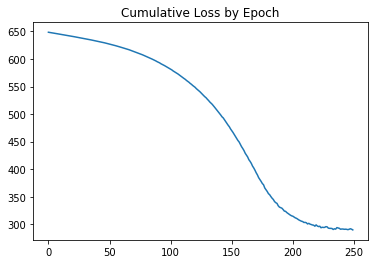

In [7]:
model = lstm.TorchLSTM(
    train_x=train.drop(COLS_TO_IGNORE, axis=1),
    train_y=train[OPEN],
    test_x=test.drop(COLS_TO_IGNORE, axis=1),
    test_y=test[OPEN],
    n_layers=2,
    n_training_batches=1,
    n_epochs=250,
    hidden_shape=100,
    dropout=0.1,
    learning_rate=.0001,
    seed=44,
)

model.fit()
prediction = model.prediction_df

In [10]:
res = test[COLS_TO_IGNORE].join(prediction)

res[DENORMALIZED_PREDICTION] = res[PREDICTION] * (df[OPEN_MAX] - df[OPEN_MIN]) + df[OPEN_MIN]
res.head()

,symbol,market_datetime,denormalized_open,open,open_min,open_max,open_1,open_2,open_3,open_4,...,open_24,open_25,open_26,open_27,open_28,open_29,open_30,symbol_KO,prediction,denormalized_prediction
999,KO,2003-10-23 05:00:00,23.625,1.462838,21.46,22.94,0.834459,1.000000,0.770270,0.766892,...,0.229730,0.162162,0.000000,0.050676,0.361486,0.405405,0.753378,1,0.807670,22.655351
1000,KO,2003-10-24 05:00:00,23.730,1.533784,21.46,22.94,0.777027,0.834459,1.000000,0.770270,...,0.087838,0.229730,0.162162,0.000000,0.050676,0.361486,0.405405,1,0.820858,22.674870
1001,KO,2003-10-27 06:00:00,23.830,1.601351,21.46,22.94,0.719595,0.777027,0.834459,1.000000,...,0.192568,0.087838,0.229730,0.162162,0.000000,0.050676,0.361486,1,0.841688,22.705698
1002,KO,2003-10-28 06:00:00,24.070,1.763514,21.46,22.94,0.837838,0.719595,0.777027,0.834459,...,0.212838,0.192568,0.087838,0.229730,0.162162,0.000000,0.050676,1,0.874329,22.754007
1003,KO,2003-10-29 06:00:00,24.250,1.885135,21.46,22.94,0.922297,0.837838,0.719595,0.777027,...,0.020270,0.212838,0.192568,0.087838,0.229730,0.162162,0.000000,1,0.927820,22.833173


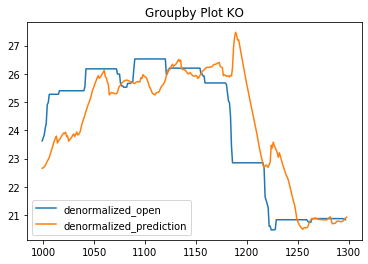

In [11]:
def plot_groupby(
    df,
    groupby,
    lines,
    title='Groupby Plot',
    n_plots=10,
    n_ticks=10,
    error_plot=False,
):
    n = 0
    plt.plot()
    for label, group in df.groupby(groupby):
        plt.title(title + ' ' + label)
        if not error_plot:
            for line in lines:
                plt.plot(group[line], label=line)

        else:
            plt.plot(
                group[lines[0]]-group[lines[1]],
                label='Error ' + label,
            )
            plt.hlines(0, xmin=group.index.min(), xmax=group.index.max())

        plt.legend()
        plt.show()
        n += 1
        if n > n_plots:
            break

plot_groupby(res, SYMBOL, lines=[DENORMALIZED_OPEN, DENORMALIZED_PREDICTION])